# 3. Symulacja numeryczna - schemat niejawny

Celem symulacji jest rozwiązanie problemu początkowo-brzegowego zdefiniowanego przez układ równań (4)-(7).

**Równania ewolucji (4)-(5):**
$$
\begin{cases}
\frac{\partial u}{\partial t} = a - u - uv^2 + d_1 \Delta u \\
\frac{\partial v}{\partial t} = uv^2 - mv + d_2 \Delta v
\end{cases}
$$

**Warunki Brzegowe (6):**
$$
u(0, y) = u(L, y), \quad v(x, 0) = v(x, L) \tag{6}
$$

**Warunki Początkowe (7):**
Symulację startujemy od stanu pustynnego z nałożonym małym losowym zaburzeniem (szumem) $\xi$:
$$
u(x, y, 0) = a, \quad v(x, y, 0) = \xi(x, y) \tag{7}
$$

### Metoda numeryczna i dyskretyzacja

Przestrzeń dyskretyzujemy **metodą różnic skończonych** na siatce $N \times N$, aproksymując operator Laplace'a $\Delta$ schematem pięciopunktowym.

Aby uniknąć konieczności iteracyjnego rozwiązywania skomplikowanego układu nieliniowego w każdym kroku, człon reakcji $f(u,v)$ uwzględniamy w chwili bieżącej $t_n$. Prowadzi to do układu równań liniowych rozwiązywanego w każdym kroku:

$$(I - h_t D \mathbf{L}) \mathbf{u}^{n+1} = \mathbf{u}^n + h_t f(\mathbf{u}^n, \mathbf{v}^n)$$

Gdzie $\mathbf{L}$ to macierz operatora Laplace'a uwzględniająca warunki periodyczne, a $I$ to macierz jednostkowa.

Start symulacji (Metoda Linearyzowana Niejawna).
a=1.8000, m=0.4500
Stosunek dyfuzji d1/d2: 500.0
Przygotowanie macierzy...
Obliczenia (10000 kroków)...
Postęp: 0% (Max v: 2.98)
Postęp: 20% (Max v: 8.64)
Postęp: 40% (Max v: 8.77)
Postęp: 60% (Max v: 8.71)
Postęp: 80% (Max v: 8.81)
Gotowe.


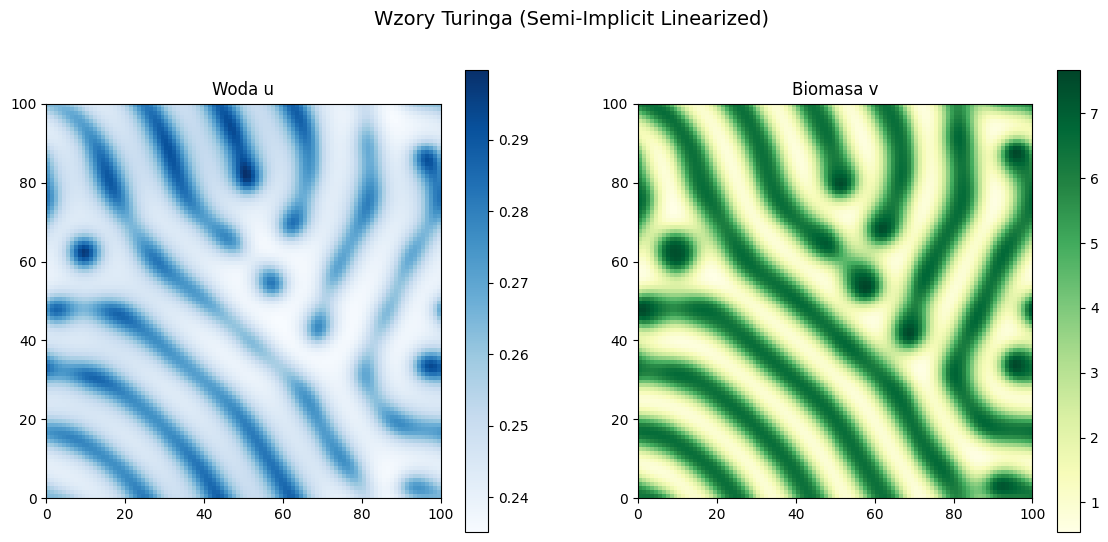

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def construct_periodic_laplacian(N):
    """buduje macierz Laplasjana z warunkami brzegowymi."""
    e = np.ones(N)
    diags = [e, -2*e, e]
    offsets = [-1, 0, 1]
    L1 = sp.spdiags(diags, offsets, N, N, format='csr')
    
    L1[0, -1] = 1
    L1[-1, 0] = 1
    
    I = sp.eye(N, format='csr')
    L2 = sp.kron(I, L1) + sp.kron(L1, I)
    return L2

class KlausmeierParameters:
    def __init__(self, A, L, R, J, M, Dw, Dn):
        self.A, self.L, self.R, self.J, self.M = A, L, R, J, M
        self.Dw, self.Dn = Dw, Dn

    def get_dimensionless_params(self):
        m = self.M / np.sqrt(self.A) if self.A > 0 else 0
        a = self.A 
        d1 = self.Dw
        d2 = self.Dn
        return {'a': self.A, 'm': self.M, 'd1': d1, 'd2': d2}

params = KlausmeierParameters(
    A=1.8,
    L=1.0, 
    R=0.5, 
    J=1.0, 
    M=0.45,
    Dw=500.0,
    Dn=1.0
)
p = params.get_dimensionless_params()
a, m = p['a'], p['m']
d1, d2 = p['d1'], p['d2']

# ustawienia symulacji
N = 100          
T_max = 1000     
dt = 0.1         
steps = int(T_max / dt)

Lap = construct_periodic_laplacian(N)
Identity = sp.eye(N*N, format='csr')

# równanie u: u_t = a - u - uv^2 + d1*Lap(u)
A_u = (1.0 + dt) * Identity - dt * d1 * Lap

# równanie v: v_t = uv^2 - m*v + d2*Lap(v)
A_v = (1.0 + dt * m) * Identity - dt * d2 * Lap

# faktoryzacja 
solve_u = spla.factorized(A_u.tocsc())
solve_v = spla.factorized(A_v.tocsc())

u_grid = np.ones((N, N)) * a
v_grid = np.ones((N, N)) * 2.0 
np.random.seed(123) 
noise = (np.random.random((N, N)) - 0.5) * 0.5 
v_grid += noise

u_flat = u_grid.flatten()
v_flat = v_grid.flatten()
